# Network Analysis methods (biologically inspired)


Nonmass-like lesion consists frequently of clusters of spatially and temporally inter-connected regions of enhancements7, so they can be modeled with graphs and its properties characterized with graph-based connectivity analysis. Typically, other features are extracted to characterize the kinetic behavior of contrast agent or the morphology of enhancing regions. Adding graph connectivity features to a CAD pipeline incurs into an increase of feature space dimensionality. The increased dimensionality poses an additional challenge. The “curse of dimensionality” occurs when the number of features becomes very large relative to the number of observations, and when further increasing the number of observations is not feasible. To avoid the “curse of dimensionality” reducing the dimensionality of the resulting feature space without losing representation ability is imperative. In addition, acquiring datasets of large numbers of MRI findings with ground truth histopathology labels is rare, since the majority of breast MRI findings are followed up with further imaging rather than with histopathology examinations. 

Therefore, the purpose of this study was to investigate whether the high-dimensional feature space resulting from graph-based features combined to other standard DEC-MRI features of nonmass-like enhancements can be effectively reduced and optimized for discriminating between benign and malignant lesions even in the case of partially-labeled datasets. Our approach is based on a clustering-based dimensionality reduction framework capable of learning a suitable feature space representation that can ultimately lead to an improved diagnostic performance of CAD for nonmass-like enhancements in breast MRI.

In [1]:
import pandas as pd
import numpy as np
import os
import os.path
import shutil
import glob
import tempfile
import subprocess
import SimpleITK as sitk

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from query_localdatabase import *
import glob
import six.moves.cPickle as pickle
import gzip
import networkx as nx

graphs_path = 'Z:\\Cristina\\Section3\\breast_MR_NME_biological\\processed_NMEs'
nxGfeatures_path = 'Z:\\Cristina\\Section3\\breast_MR_NME_biological\\NMEs_SER_nxgmetrics'
mha_data_loc= 'Z:\\Cristina\mha'
processed_path = r'Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data'


# A malignant lesion: INVASIVE DUCTAL

In [10]:
lesion_id = 108
localdata = Querylocaldb()
dflesion  = localdata.querylocalDatabase_wRad(lesion_id)      
cond = dflesion[0]
lesion_record = dflesion[1]
roi_record = dflesion[2]
nmlesion_record = dflesion[3]
StudyID = lesion_record['cad_pt_no_txt']
AccessionN = lesion_record['exam_a_number_txt']
DynSeries_id = nmlesion_record['DynSeries_id']  
roi_id = roi_record['roi_id']
label = roi_record['roi_label']
c = roi_record['roi_centroid']
centroid = c[c.find("(")+1:c.find(")")].split(',')
zslice = int(roi_record['zslice'])
p1 = roi_record['patch_diag1']
patch_diag1 = p1[p1.find("(")+1:p1.find(")")].split(',')
patch_diag1 = [float(p) for p in patch_diag1]
p2 = roi_record['patch_diag2']
patch_diag2 = p2[p2.find("(")+1:p2.find(")")].split(',')
patch_diag2 = [float(p) for p in patch_diag2]    

print("====================")
print('StudyID: ', StudyID)
print('AccessionN: ', AccessionN)
print('DynSeries_id: ', DynSeries_id)
print('label: ', label)
print('lesion_id: ', lesion_id)
print('roi_id: ', roi_id)
print("====================")

#############################
###### 1) Accesing mc images and lesion prob maps
#############################
# get dynmic series info
precontrast_id = int(DynSeries_id) 
DynSeries_nums = [str(n) for n in range(precontrast_id,precontrast_id+5)]

print "Reading MRI volumes..."
DynSeries_imagefiles = []
mriVols = []
preCon_filename = '{}_{}_{}'.format(StudyID.zfill(4),AccessionN,DynSeries_nums[0] )
print preCon_filename
glob_result = glob.glob(os.path.join(processed_path,preCon_filename+'@*')) #'*':do not to know the exactly acquistion time
if glob_result != []:
    filename = glob_result[0]
# read Volumnes
DynSeries_imagefiles.append(filename)
mriVolDICOM = sitk.ReadImage(filename)
mriVols.append( sitk.GetArrayFromImage(sitk.Cast(mriVolDICOM,sitk.sitkFloat32)) )
mriVolSize = mriVolDICOM.GetSize()
print "MRI volumes Size = [%f,%f,%f]..." % mriVolSize
mriVolSpacing = mriVolDICOM.GetSpacing()
print "MRI volumes spacing = [%f,%f,%f]..." % mriVolSpacing
mriVolVoxratio = mriVolSpacing[2]/mriVolSpacing[0]        

ext_x = [int(ex) for ex in [np.min([patch_diag1[0],patch_diag2[0]])-25,np.max([patch_diag1[0],patch_diag2[0]])+25] ] 
ext_y = [int(ey) for ey in [np.min([patch_diag1[1],patch_diag2[1]])-45,np.max([patch_diag1[1],patch_diag2[1]])+25] ] 

for j in range(1,5):
    DynSeries_filename = '{}_{}_{}'.format(StudyID.zfill(4),AccessionN,DynSeries_nums[j] )
    glob_result = glob.glob(os.path.join(processed_path,DynSeries_filename+'@*')) 
    if glob_result != []:
        filename = [name for name in glob_result if '_mc' in name][0] #glob_result[0]
        print filename

    # add side info from the side of the lesion
    DynSeries_imagefiles.append(filename)
    # read Volumnes
    mriVolDICOM = sitk.ReadImage(filename)
    mriVols.append( sitk.GetArrayFromImage(sitk.Cast(sitk.ReadImage(DynSeries_imagefiles[j]),sitk.sitkFloat32)) )

    
## to read graph
with gzip.open(os.path.join(graphs_path,'{}_{}_{}_{}_lesion_nxgraph.pklz'.format(roi_id,StudyID.zfill(4),AccessionN,label)), 'rb') as f:
    try:
        lesionG = pickle.load(f, encoding='latin1')
    except:
        lesionG = pickle.load(f)

import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : False, "legend.frameon": True})
sns.set_context("paper", font_scale=2)  
nodes = [u for (u,v) in lesionG.nodes(data=True)]
pts = [v.values()[0] for (u,v) in lesionG.nodes(data=True)]
pos = dict(zip(nodes,pts))


Executing local connection...
NON-MASS
----------------------------------------------------------

('StudyID: ', u'0572')
('AccessionN: ', u'4681582')
('DynSeries_id: ', u'600')
('label: ', u'M')
('lesion_id: ', 108)
('roi_id: ', 107)
Reading MRI volumes...
0572_4681582_600
MRI volumes Size = [512.000000,512.000000,80.000000]...
MRI volumes spacing = [0.332000,0.332000,3.000000]...
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\0572_4681582_601@073306_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\0572_4681582_602@073448_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\0572_4681582_603@073631_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\0572_4681582_604@073813_mc.mha


# Degree
The degree of a given node x is the number of links in L which contain it. The degree D(x) can be found as follows:
$$ D(x)= |\{ y \in N : \{x, y\} \in N\} | $$

Nodes with high degree are in more dense areas of enhancement and likely represent higher enhancement, but degree is dependent on cluster size. The degree of a node is very similar in many ways to clustering coefficient, as it provides information about the shape of the network and feedback for the threshold setting. An example is shown below, Nodes with high values for a particular method are highlighted (orange)

source: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality

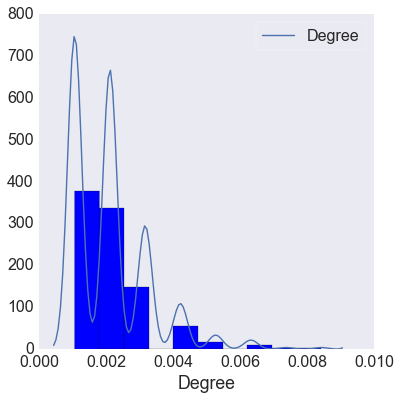

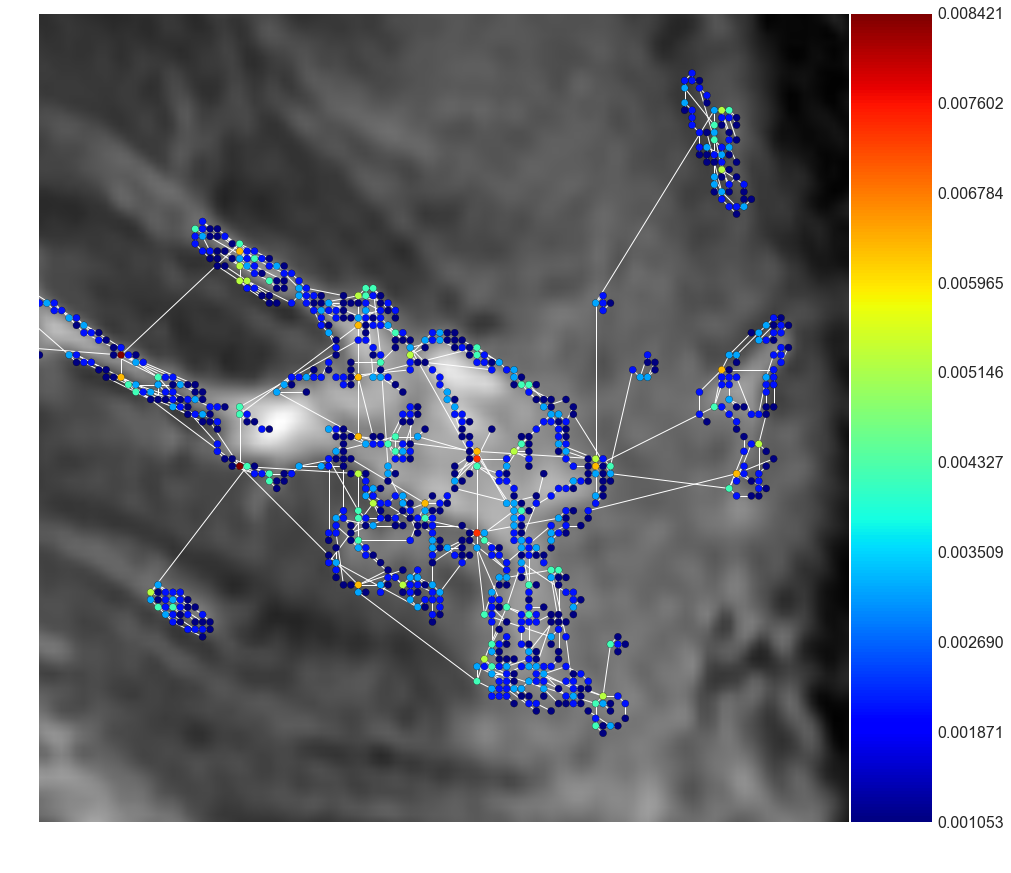

In [11]:
Degree = nx.degree_centrality(lesionG) 
pd_Degree = pd.Series(Degree.values(), name="Degree")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(Degree.values(),color='b')
sns.distplot(pd_Degree, label="Degree", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
Dvalues = np.asarray([Degree.get(node) for node in lesionG.nodes()])
v = np.linspace(min(Dvalues), max(Dvalues), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=Dvalues, cmap=plt.cm.jet,  
                 node_vmin=np.min(Dvalues), node_vmax=np.max(Dvalues),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax,  width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('Degree nodes')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 

# Average_neighbor_degree
The average degree of the neighborhood of each node. The average degree of a node i for weighted graphs is [1]:

$$ k_{nn,i} = \frac{1}{s_i} \sum_{j \in N(i)} w_{ij} k_j $$

where  $N(i)$  are the neighbors of node  $i$  and $kj$ is the degree of node  $j$  which belongs to $N(i)$.
$w_{ij}$ is the weight of the edge that links $i$ and $j$ and  $s_i$ is the weighted degree of node  $i$

[1] A. Barrat, M. Barthélemy, R. Pastor-Satorras, and A. Vespignani, “The architecture of complex weighted networks”. PNAS 101 (11): 3747–3752 (2004).

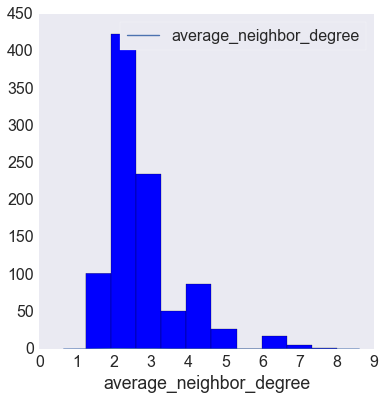

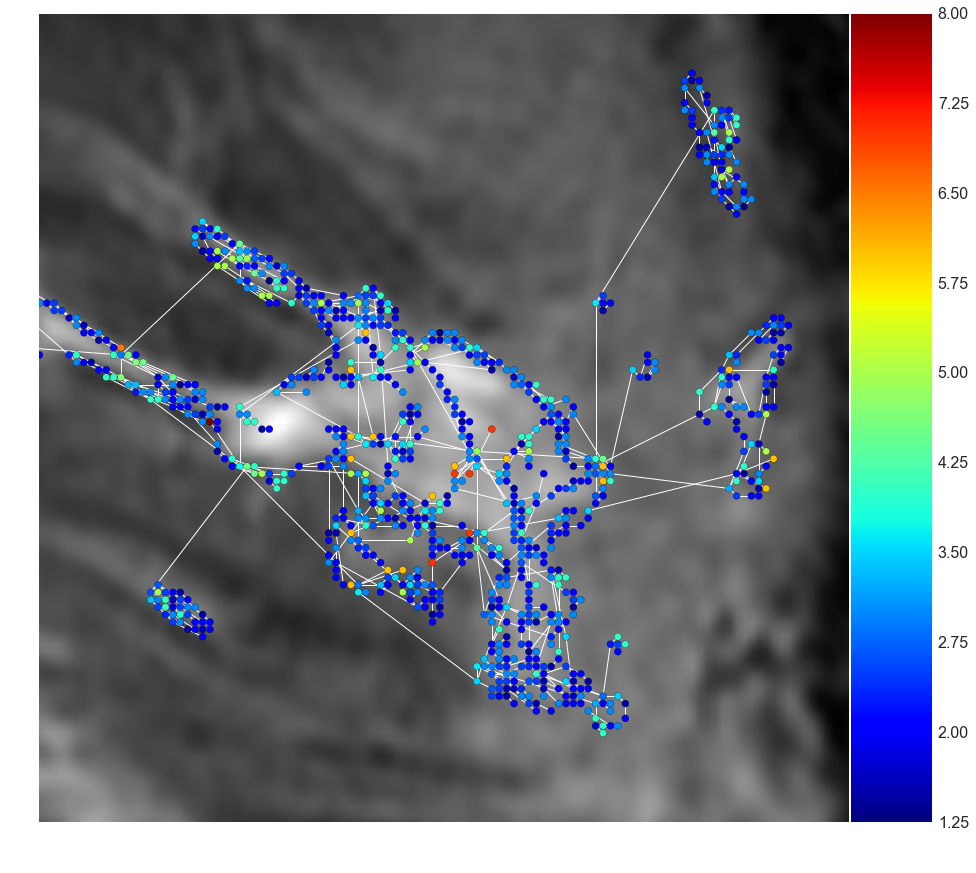

In [12]:
average_neighbor_degree = nx.average_neighbor_degree(lesionG)
pd_average_neighbor_degree = pd.Series(average_neighbor_degree.values(), name="average_neighbor_degree")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(average_neighbor_degree.values(),color='b')
sns.distplot(pd_average_neighbor_degree, label="average_neighbor_degree", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
average_neighbor_degreevalues = np.asarray([average_neighbor_degree.get(node) for node in lesionG.nodes()])
v = np.linspace(min(average_neighbor_degreevalues), max(average_neighbor_degreevalues), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=average_neighbor_degreevalues, cmap=plt.cm.jet,  
                 node_vmin=min(average_neighbor_degreevalues), node_vmax=max(average_neighbor_degreevalues),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax,  width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('average_neighbor_degree')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 

# Betweenness centrality for nodes.

Betweenness is part of centrality theory, and it is one measure of the importance of a particular node to its cluster. Specifically, the Betweenness is the number of shortest paths that use that node s over all the shortest paths between every node. Given the set of all shortest paths S (determined by Dijkstra’s algorithm), the betweenness B can be found as follows:
$$ B(x)= \frac{|s|}{|\mathbf{S}|}: x \in Q, Q \in S $$
 
High Betweenness would mean that a node is important to the structure of a network or important in connecting two enahncing regions into one cluster.
Compute the shortest-path betweenness centrality for nodes.
Betweenness centrality of a node  vv  is the sum of the fraction of all-pairs shortest paths that pass through  vv :
$$ c_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)} $$ 
 
where  $V$  is the set of nodes,  $σ(s,t)$  is the number of shortest  $(s,t)−paths$, and  $σ(s,t|v)$  is the number of those paths passing through some node  $v$  other than  $s,t$.

If  %s=t%, and  $σ(s,t)=1$ , and if  %v \in s,t,σ(s,t|v)=0%

source: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality

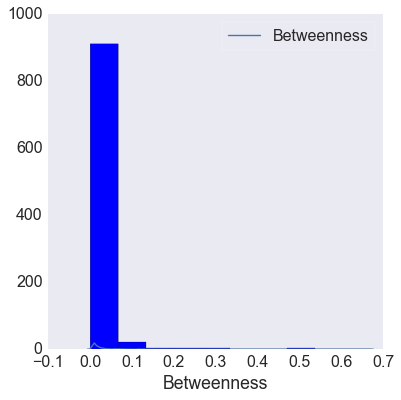

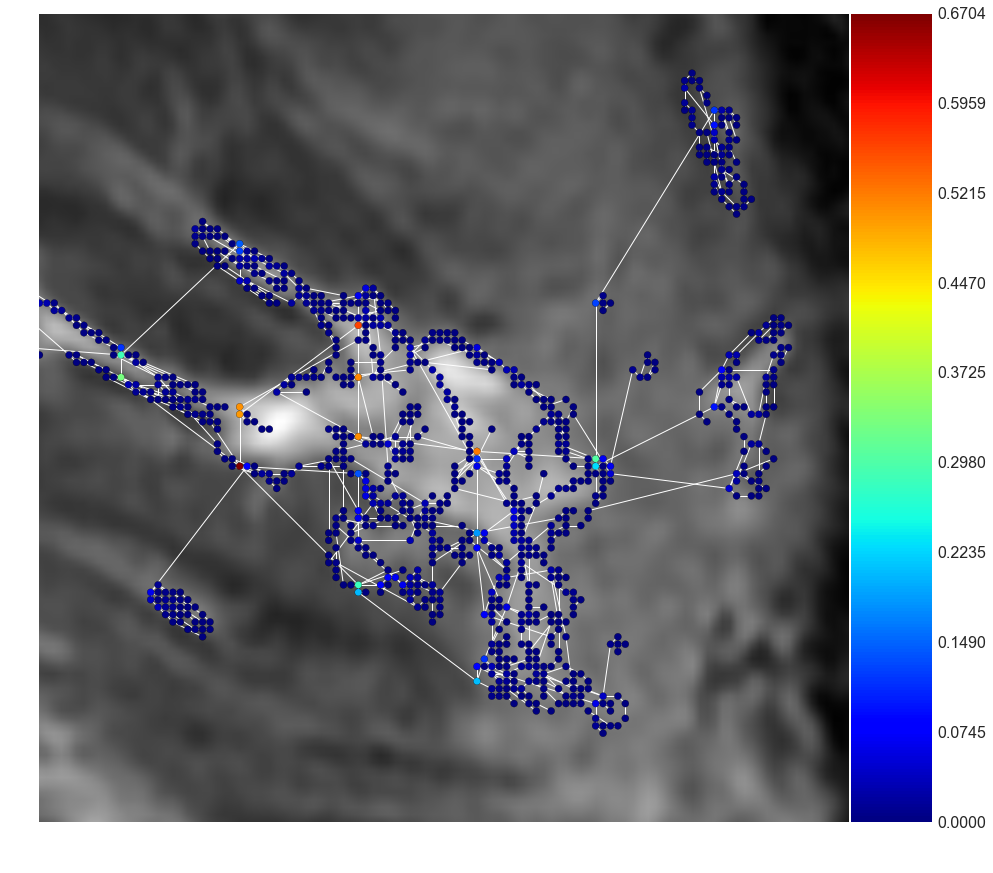

In [13]:
Betweenness = nx.betweenness_centrality(lesionG)
pd_Betweenness = pd.Series(Betweenness.values(), name="Betweenness")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(Betweenness.values(),color='b')
sns.distplot(pd_Betweenness, label="Betweenness", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
Betweennessvalues = np.asarray([Betweenness.get(node) for node in lesionG.nodes()])
v = np.linspace(min(Betweennessvalues), max(Betweennessvalues), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=Betweennessvalues, cmap=plt.cm.jet,  
                 node_vmin=min(Betweennessvalues), node_vmax=max(Betweennessvalues),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('Degree nodes')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 

# Eccentricity a Distance Measure

The eccentricity of a node v is the maximum distance from v to all other nodes in G.

https://networkx.readthedocs.io/en/stable/reference/algorithms.distance_measures.html

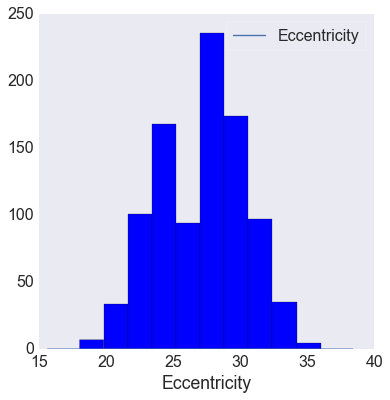

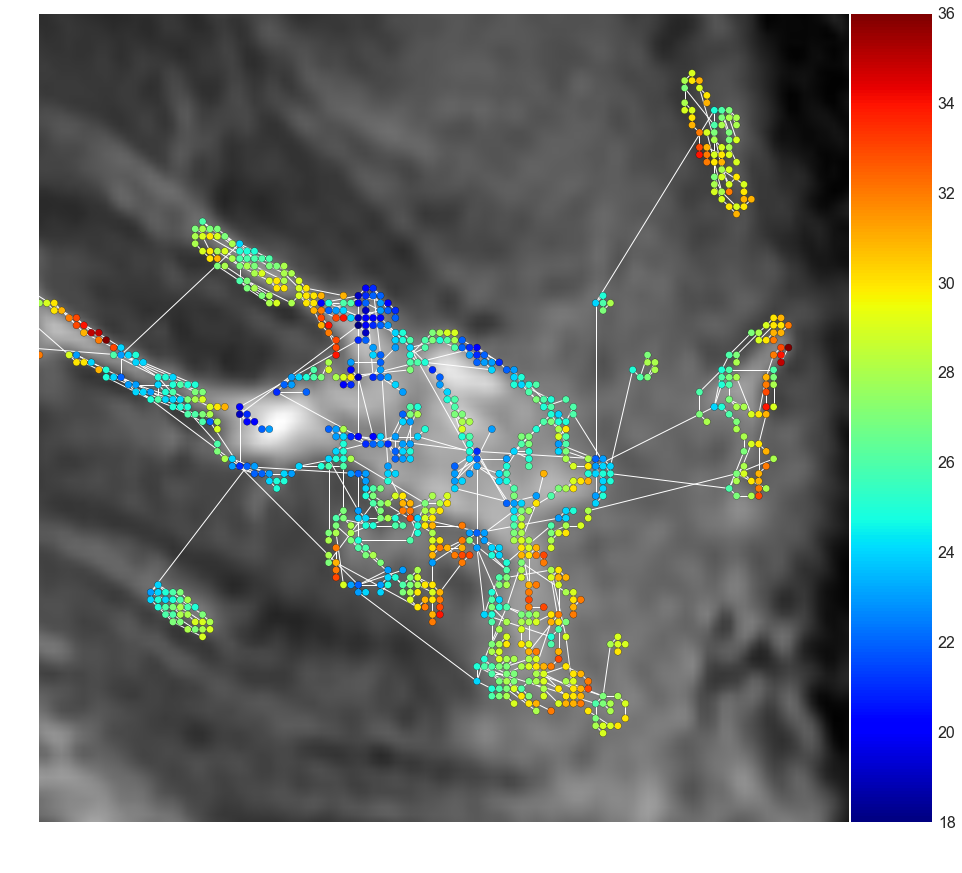

In [14]:
Ecc = nx.eccentricity(lesionG)                
pd_eccentricity = pd.Series(Ecc.values(), name="Eccentricity")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(Ecc.values(),color='b')
sns.distplot(pd_eccentricity, label="Eccentricity", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
Eccvalues = np.asarray([Ecc.get(node) for node in lesionG.nodes()])
v = np.linspace(min(Eccvalues), max(Eccvalues), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=Eccvalues, cmap=plt.cm.jet,  
                 node_vmin=min(Eccvalues), node_vmax=max(Eccvalues),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('Eccentricity')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 

# Closeness centrality for nodes.
Closeness centrality [1] of a node  $u$  is the reciprocal of the sum of the shortest path distances from  $u$  to all  $n−1$  other nodes. Since the sum of distances depends on the number of nodes in the graph, closeness is normalized by the sum of minimum possible distances  $n−1$.
$$ C(u) = \frac{n - 1}{\sum_{v=1}^{n-1} d(v, u)} $$
 
where  $d(v,u)$  is the shortest-path distance between  $v$  and  $u$, and $n$  is the number of nodes in the graph.

Notice that higher values of closeness indicate higher centrality.

### Notes
The closeness centrality is normalized to  $ (n-1)/(|G|-1)$ where $n$  is the number of nodes in the connected part of graph containing the node. If the graph is not completely connected, this algorithm computes the closeness centrality for each connected part separately.

If the  $distance$ keyword is set to an edge attribute key then the shortest-path length will be computed using Dijkstra's algorithm with that edge attribute as the edge weight.

References
[1] Freeman, L.C., 1979. Centrality in networks: I.Conceptual clarification. Social Networks 1, 215--239. http://www.soc.ucsb.edu/faculty/friedkin/Syllabi/Soc146/Freeman78.PDF

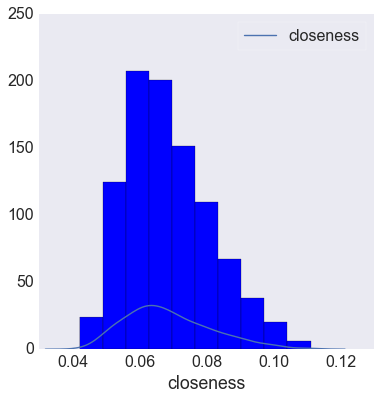

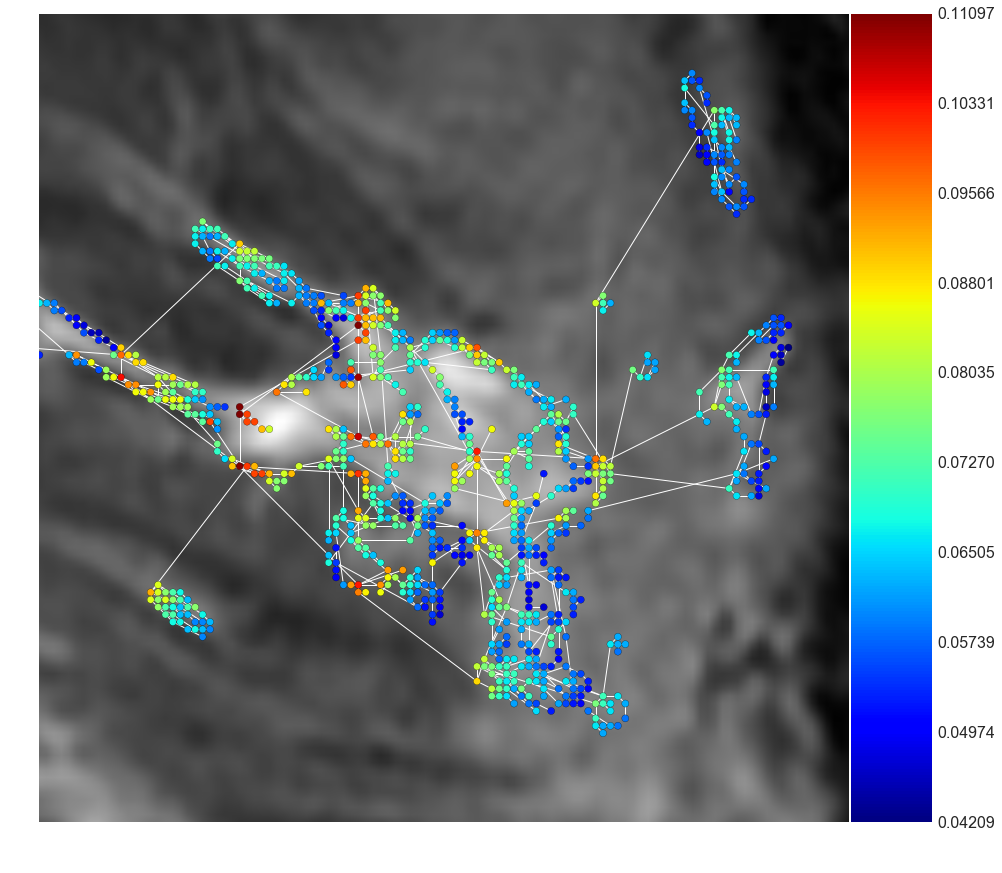

In [15]:
closeness = nx.closeness_centrality(lesionG)
pd_closeness = pd.Series(closeness.values(), name="closeness")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(closeness.values(),color='b')
sns.distplot(pd_closeness, label="closeness", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
Closenvalues = np.asarray([closeness.get(node) for node in lesionG.nodes()])
v = np.linspace(min(Closenvalues), max(Closenvalues), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=Closenvalues, cmap=plt.cm.jet,  
                 node_vmin=min(Closenvalues), node_vmax=max(Closenvalues),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('Closeness')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 

# Preferential_attachment

Compute the preferential attachment score of all node pairs in ebunch.

Preferential attachment score of  uu  and  vv  is defined as:

$$ |\Gamma(u)| |\Gamma(v)| $$
where $ |\Gamma(u)|$  denotes the set of neighbors of  $u$ 

References
[1] D. Liben-Nowell, J. Kleinberg. The Link Prediction Problem for Social Networks (2004). http://www.cs.cornell.edu/home/kleinber/link-pred.pdf

(array([  1.07100000e+03,   3.17000000e+02,   8.20000000e+01,
          4.90000000e+01,   1.30000000e+01,   8.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1. ,   7.3,  13.6,  19.9,  26.2,  32.5,  38.8,  45.1,  51.4,
         57.7,  64. ]),
 <a list of 10 Patch objects>)

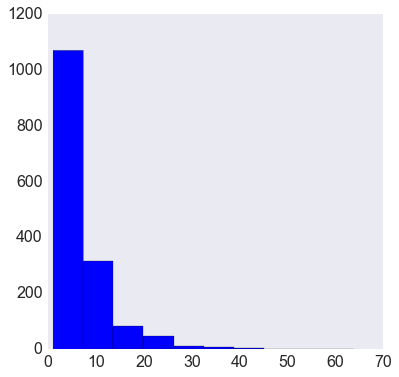

In [16]:
preferential_attachment = []
import itertools
for nij  in nodes:
    #  Preferential attachment score will be computed for each pair of nodes given in the iterable. 
    # The pairs must be given as 2-tuples (u, v) where u and v are nodes in the graph. 
    preds = nx.preferential_attachment(lesionG, ebunch=itertools.combinations(lesionG.neighbors_iter(nij), 2))
    for u, v, p in preds:
        '(%d, %d) -> %f' % (u, v, p)
        preferential_attachment.append(p)

pd_preferential_attachment = pd.Series(preferential_attachment, name="preferential_attachment")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(preferential_attachment, color='b')


#  Betweenness centrality for edges

Betweenness centrality of an edge  $e$  is the sum of the fraction of all-pairs shortest paths that pass through  $e$:
$$ c_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|e)}{\sigma(s, t)} $$
 
where  $V$  is the set of nodes,  $sigma(s,t)$  is the number of shortest  $(s,t)−paths$, and  $σ(s,t|e)$  is the number of those paths passing through edge  $e$  [2].

### Notes
The algorithm is from Ulrik Brandes [1]. For weighted graphs the edge weights must be greater than zero. Zero edge weights can produce an infinite number of equal length paths between pairs of nodes.

### References
[1] A Faster Algorithm for Betweenness Centrality. Ulrik Brandes, Journal of Mathematical Sociology 25(2):163-177, 2001. http://www.inf.uni-konstanz.de/algo/publications/b-fabc-01.pdf 

[2] Ulrik Brandes: On Variants of Shortest-Path Betweenness Centrality and their Generic Computation. Social Networks 30(2):136-145, 2008. http://www.inf.uni-konstanz.de/algo/publications/b-vspbc-08.pdf

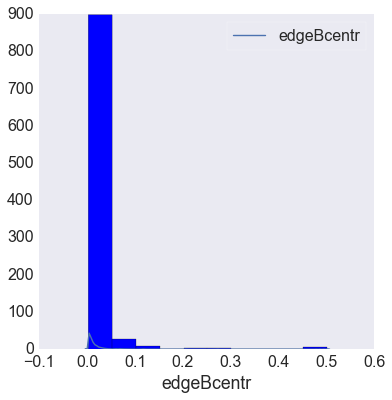

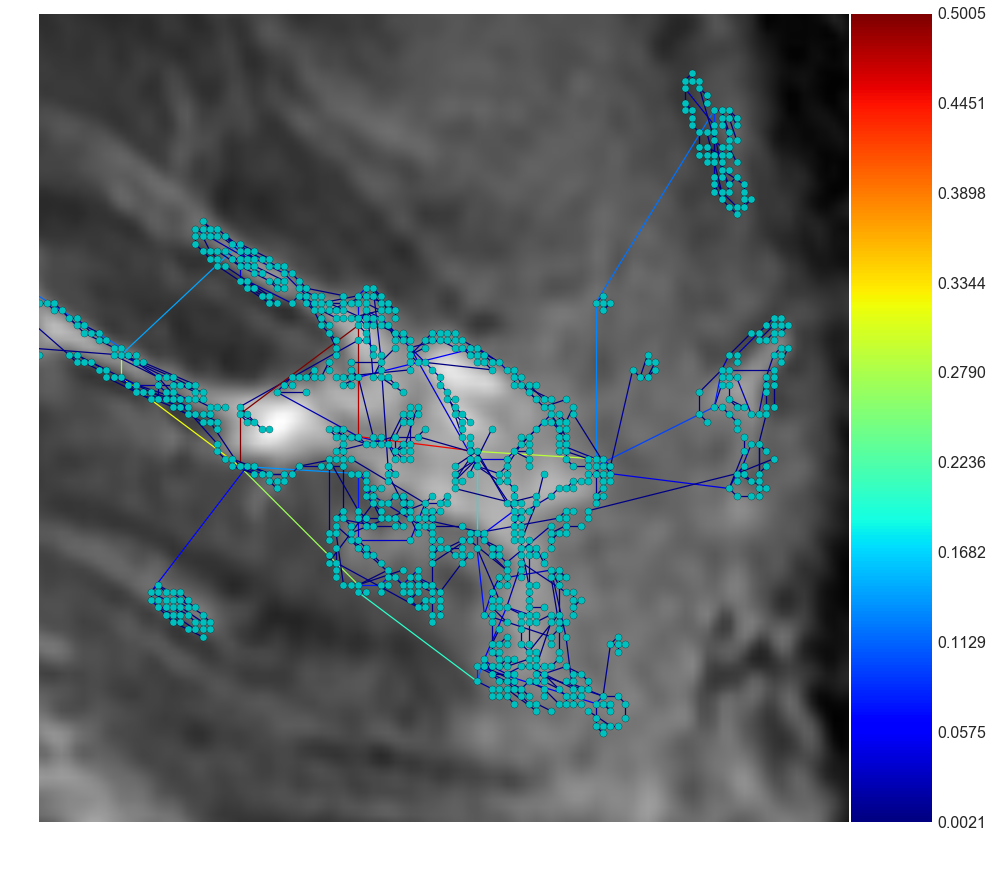

In [17]:
edgeBcentr = nx.edge_betweenness_centrality(lesionG)
pd_edgeBcentr = pd.Series(edgeBcentr.values(), name="edgeBcentr")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(edgeBcentr.values(),color='b')
sns.distplot(pd_edgeBcentr, label="edgeBcentr", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
edgeBcentrvalues = np.asarray([edgeBcentr.get(ed) for ed in lesionG.edges()])
v = np.linspace(min(edgeBcentrvalues), max(edgeBcentrvalues), 10, endpoint=True) 
nxg = nx.draw_networkx_edges(lesionG, pos, ax=ax, edge_color=edgeBcentrvalues, edge_cmap=plt.cm.jet,  
                 edge_vmin=min(edgeBcentrvalues), edge_vmax=max(edgeBcentrvalues),
                 with_labels=False, width=1.25)
nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_size=50, node_color='c')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('edgeBcentr')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)

# Communicability centrality for nodes
Communicability centrality, also called subgraph centrality, of a node n is the sum of closed walks of all lengths starting and ending at node n.

### Notes
This version of the algorithm computes eigenvalues and eigenvectors of the adjacency matrix.
Communicability centrality of a node u in G can be found using a spectral decomposition of the adjacency matrix [1] [2],

$$ SC(u)=\sum_{j=1}^{N}(v_{j}^{u})^2 e^{\lambda_{j}}, $$ 
 
where  $vj$  is an eigenvector of the adjacency matrix $A$ of $G$  corresponding corresponding to the eigenvalue $λj$.

### References

[1] Ernesto Estrada, Juan A. Rodriguez-Velazquez, “Subgraph centrality in complex networks”, Physical Review E 71, 056103 (2005). http://arxiv.org/abs/cond-mat/0504730 

[2] Ernesto Estrada, Naomichi Hatano, “Communicability in complex networks”, Phys. Rev. E 77, 036111 (2008). http://arxiv.org/abs/0707.0756

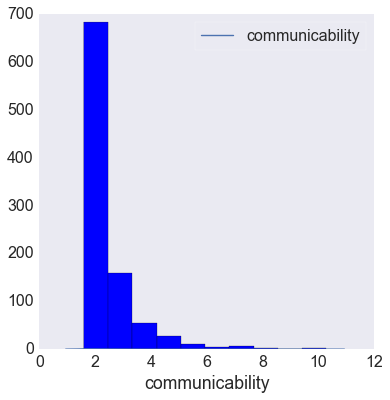

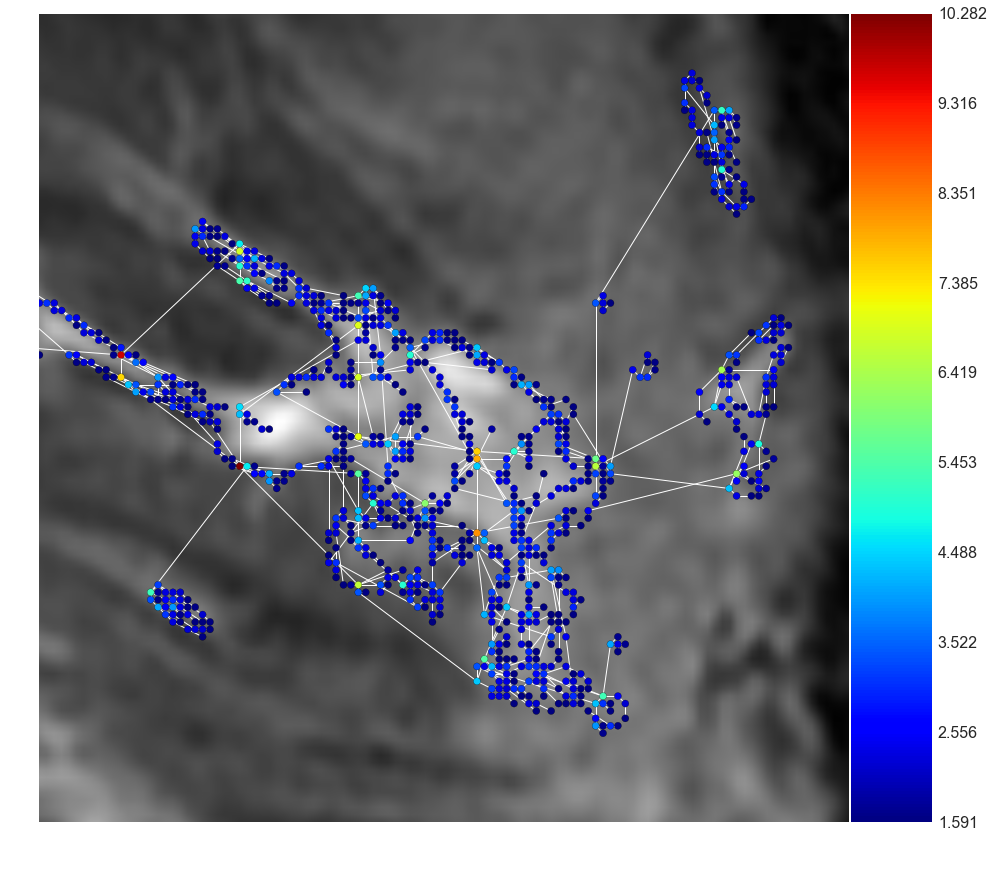

In [18]:
communicability = nx.communicability_centrality(lesionG)
pd_communicability = pd.Series(communicability.values(), name="communicability")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(communicability.values(),color='b')
sns.distplot(pd_communicability, label="communicability", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
communicabvalues = np.asarray([communicability.get(node) for node in lesionG.nodes()])
v = np.linspace(min(communicabvalues), max(communicabvalues), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=communicabvalues, cmap=plt.cm.jet,  
                 node_vmin=min(communicabvalues), node_vmax=max(communicabvalues),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('communicability')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 

# PageRank of the nodes

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.

### Notes
The eigenvector calculation uses NumPy’s interface to the LAPACK eigenvalue solvers. This will be the fastest and most accurate for small graphs.

### References
[1] A. Langville and C. Meyer, “A survey of eigenvector methods of web information retrieval.” http://citeseer.ist.psu.edu/713792.html 

[2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry, The PageRank citation ranking: Bringing order to the Web. 1999 http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf

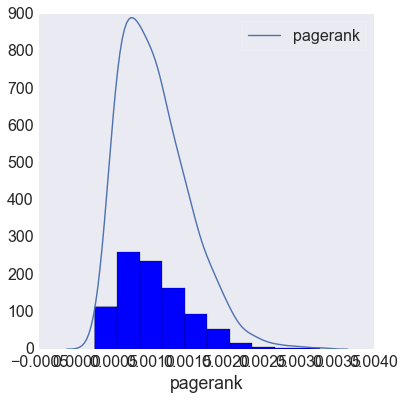

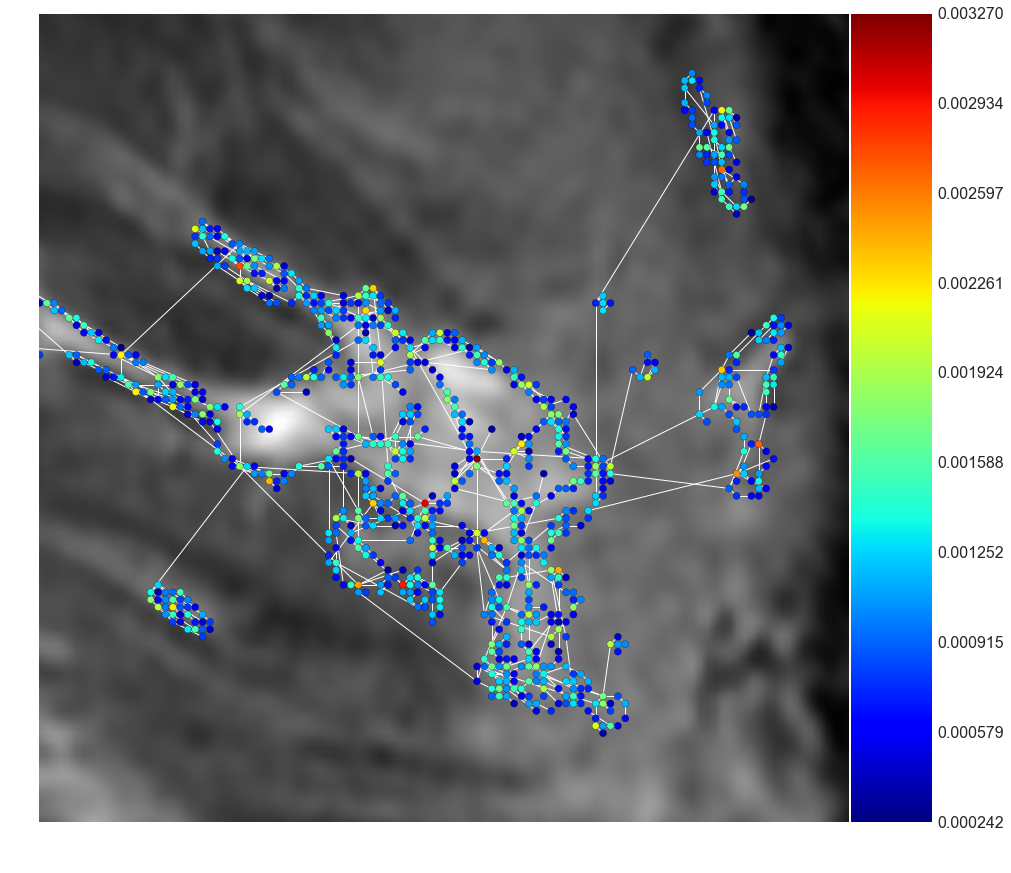

In [19]:
pagerank = nx.pagerank_numpy(lesionG)
pd_pagerank = pd.Series(pagerank.values(), name="pagerank")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(pagerank.values(),color='b')
sns.distplot(pd_pagerank, label="pagerank", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
pagerankvals = np.asarray([pagerank.get(node) for node in lesionG.nodes()])
v = np.linspace(min(pagerankvals), max(pagerankvals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=pagerankvals, cmap=plt.cm.jet,  
                 node_vmin=min(pagerankvals), node_vmax=max(pagerankvals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('pagerank')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 

# HITS hubs and authorities values for nodes.

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

The eigenvector calculation is done by the power iteration method and has no guarantee of convergence. The iteration will stop after max_iter iterations or an error tolerance of number_of_nodes(G)*tol has been reached.

The HITS algorithm was designed for directed graphs but this algorithm does not check if the input graph is directed and will execute on undirected graphs.

### References
[1] A. Langville and C. Meyer, “A survey of eigenvector methods of web information retrieval.” http://citeseer.ist.psu.edu/713792.html

[2] Jon Kleinberg, Authoritative sources in a hyperlinked environment Journal of the ACM 46 (5): 604-32, 1999. doi:10.1145/324133.324140. http://www.cs.cornell.edu/home/kleinber/auth.pdf.

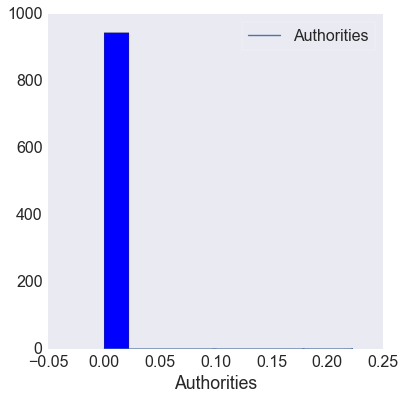

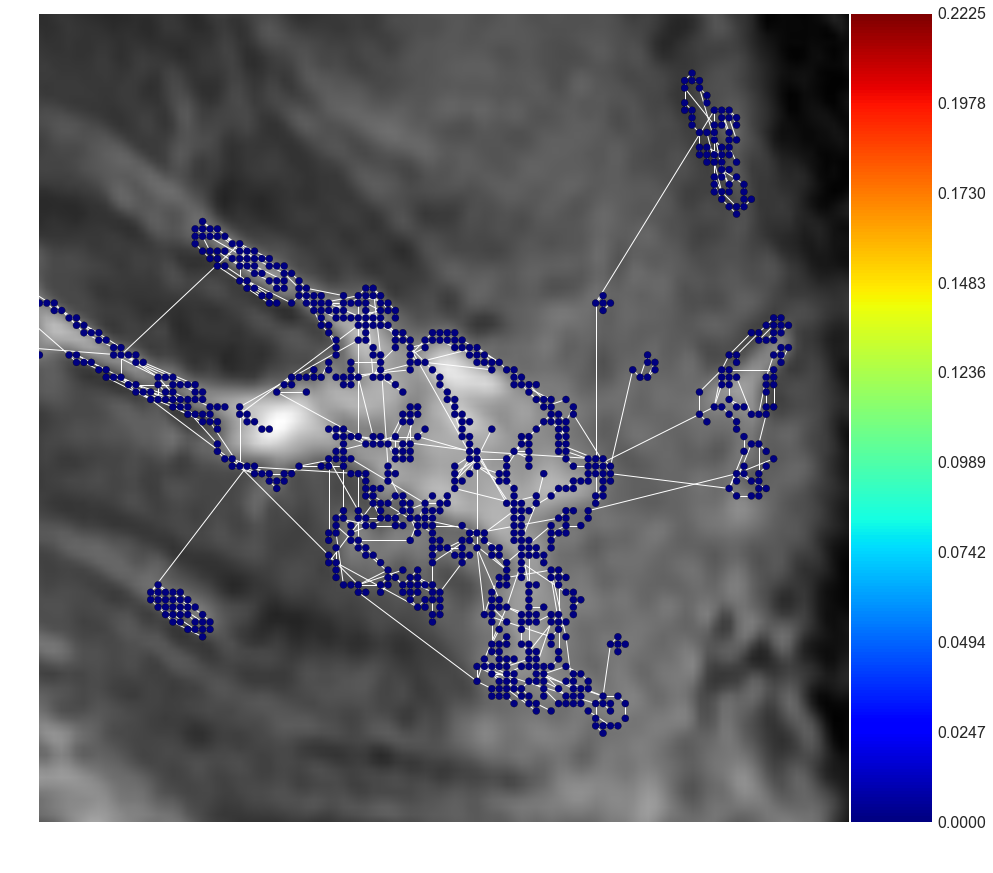

In [20]:
aut, hits = nx.hits(lesionG,max_iter=5000)
pd_aut = pd.Series(aut.values(), name="Authorities")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(aut.values(),color='b')
sns.distplot(pd_aut, label="Authorities", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
autvals = np.asarray([aut.get(node) for node in lesionG.nodes()])
v = np.linspace(min(autvals), max(autvals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=autvals, cmap=plt.cm.jet,  
                 node_vmin=min(autvals), node_vmax=max(autvals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('Authorities')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)                 

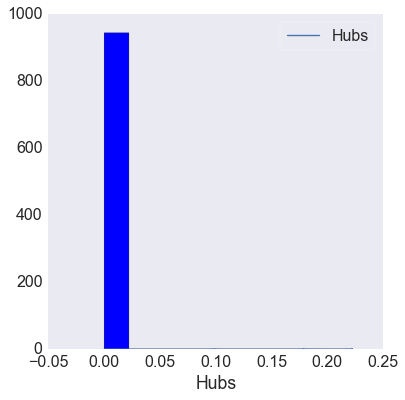

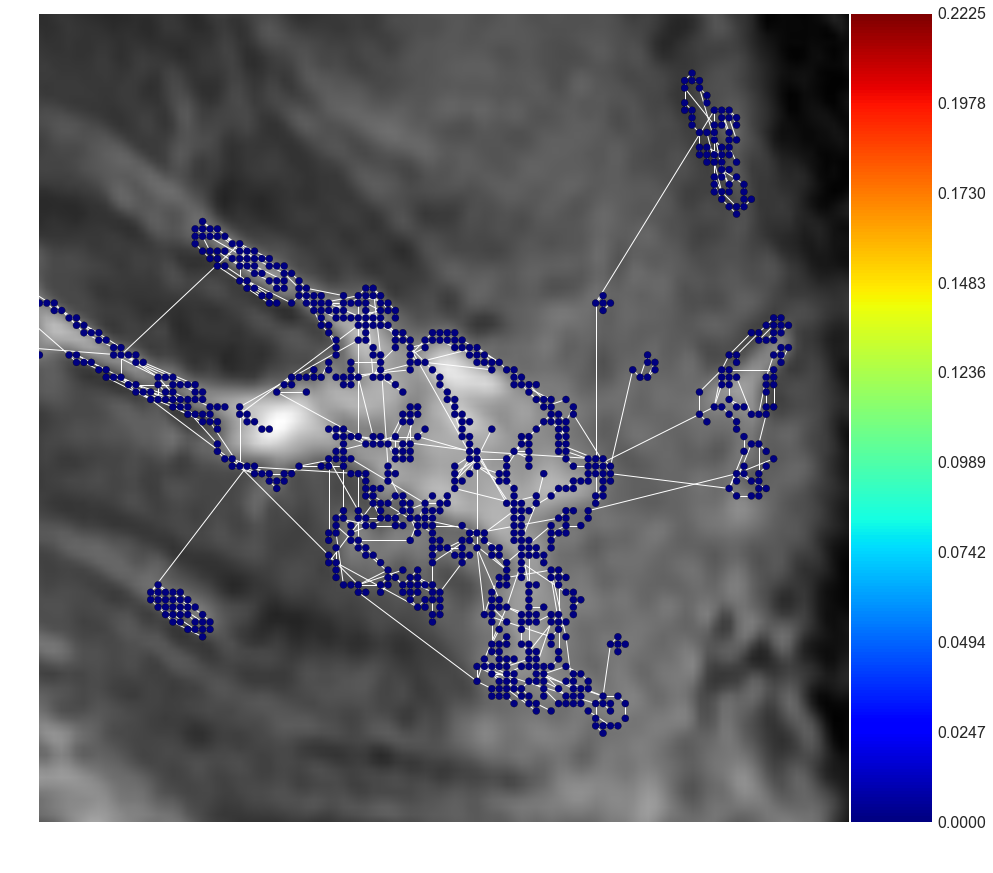

In [21]:
pd_hits = pd.Series(hits.values(), name="Hubs")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(hits.values(),color='b')
sns.distplot(pd_hits, label="Hubs", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
hitsvals = np.asarray([hits.get(node) for node in lesionG.nodes()])
v = np.linspace(min(hitsvals), max(hitsvals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=hitsvals, cmap=plt.cm.jet,  
                 node_vmin=min(hitsvals), node_vmax=max(hitsvals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('Hubs')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)     

# Current-flow closeness centrality for nodes.

Current-flow closeness centrality is variant of closeness centrality based on effective resistance between nodes in a network. This metric is also known as information centrality.

### Notes
The algorithm is from Brandes [1].
See also [2] for the original definition of information centrality.

### References
[1] Ulrik Brandes and Daniel Fleischer, Centrality Measures Based on Current Flow. Proc. 22nd Symp. Theoretical Aspects of Computer Science (STACS ‘05). LNCS 3404, pp. 533-544. Springer-Verlag, 2005. http://www.inf.uni-konstanz.de/algo/publications/bf-cmbcf-05.pdf

[2] Karen Stephenson and Marvin Zelen: Rethinking centrality: Methods and examples. Social Networks 11(1):1-37, 1989. http://dx.doi.org/10.1016/0378-8733(89)90016-6

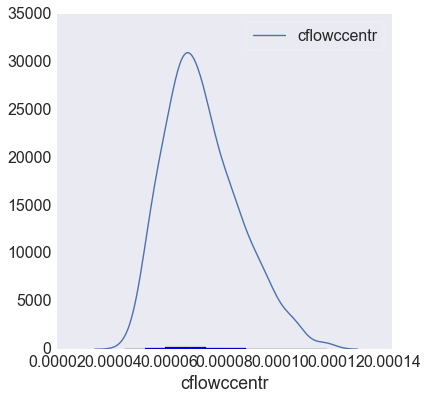

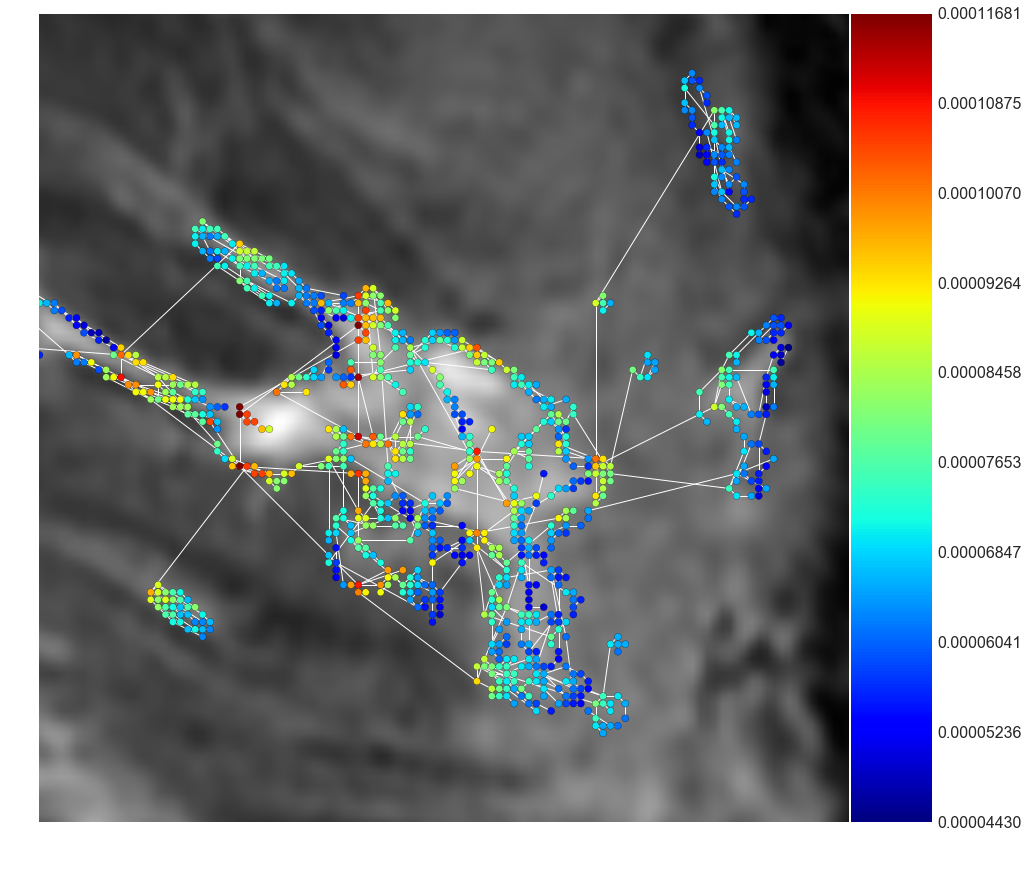

In [22]:
cflowccentr = nx.current_flow_closeness_centrality(lesionG, weight=None)
pd_cflowccentr = pd.Series(cflowccentr.values(), name="cflowccentr")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(cflowccentr.values(),color='b')
sns.distplot(pd_cflowccentr, label="cflowccentr", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
cflowccentrvals = np.asarray([cflowccentr.get(node) for node in lesionG.nodes()])
v = np.linspace(min(cflowccentrvals), max(cflowccentrvals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=cflowccentrvals, cmap=plt.cm.jet,  
                 node_vmin=min(cflowccentrvals), node_vmax=max(cflowccentrvals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('cflowccentr')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)      

# Current-flow betweenness centrality for nodes.
Current-flow betweenness centrality uses an electrical current model for information spreading in contrast to betweenness centrality which uses shortest paths.

Current-flow betweenness centrality is also known as random-walk betweenness centrality [2].


### References
[1] Centrality Measures Based on Current Flow. Ulrik Brandes and Daniel Fleischer, Proc. 22nd Symp. Theoretical Aspects of Computer Science (STACS ‘05). LNCS 3404, pp. 533-544. Springer-Verlag, 2005. http://www.inf.uni-konstanz.de/algo/publications/bf-cmbcf-05.pdf

[2] A measure of betweenness centrality based on random walks, M. E. J. Newman, Social Networks 27, 39-54 (2005).

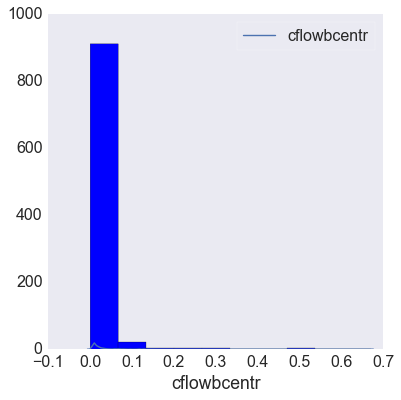

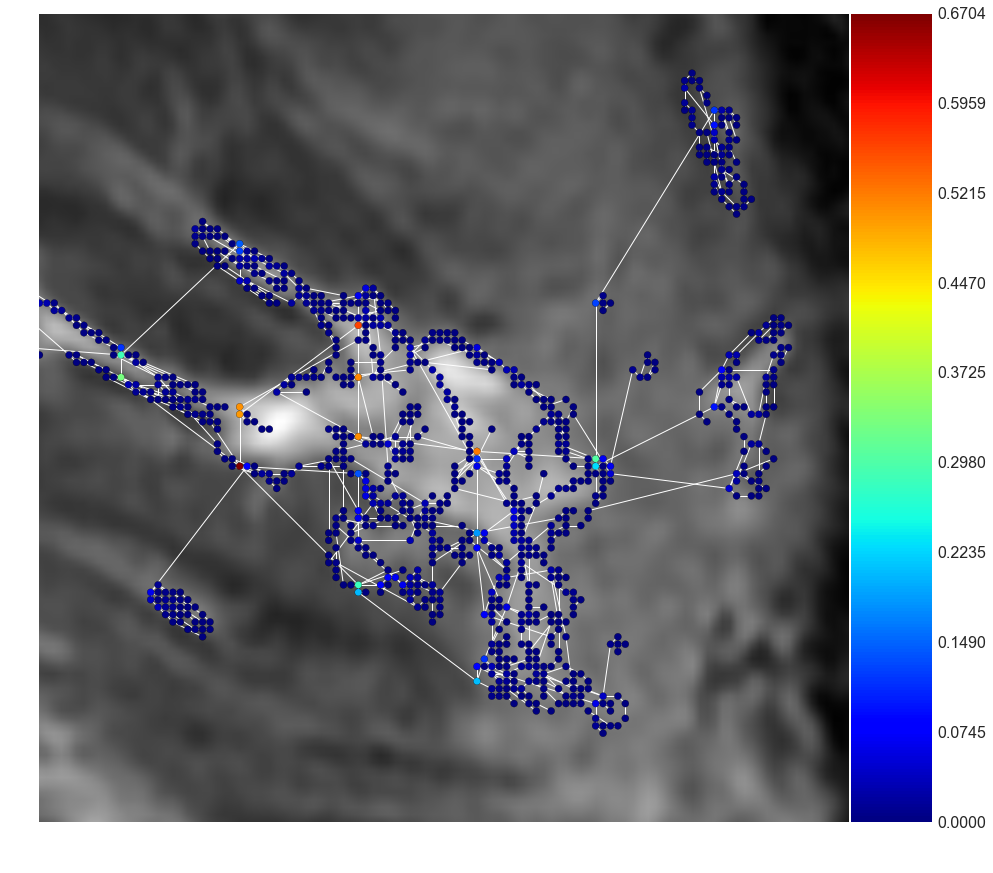

In [23]:
cflowbcentr = nx.current_flow_betweenness_centrality(lesionG, weight=None)
pd_cflowbcentr = pd.Series(cflowbcentr.values(), name="cflowbcentr")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(cflowbcentr.values(),color='b')
sns.distplot(pd_cflowbcentr, label="cflowbcentr", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
cflowbcentrvals = np.asarray([cflowbcentr.get(node) for node in lesionG.nodes()])
v = np.linspace(min(cflowbcentrvals), max(cflowbcentrvals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=cflowbcentrvals, cmap=plt.cm.jet,  
                 node_vmin=min(cflowbcentrvals), node_vmax=max(cflowbcentrvals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('cflowbcentr')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)    

# Current-flow betweenness centrality for edges.

Current-flow betweenness centrality uses an electrical current model for information spreading in contrast to betweenness centrality which uses shortest paths.

Current-flow betweenness centrality is also known as random-walk betweenness centrality [2]

### Notes
Current-flow betweenness can be computed in $O(I(n-1)+mn \log (n)$ time [1], where $I(n-1)$ is the time needed to compute the inverse Laplacian. For a full matrix this is $O(n^3)$ but using sparse methods you can achieve $O(nm{\sqrt k})$ where $k$ is the Laplacian matrix condition number.

The space required is $O(nw)$ where `w is the width of the sparse Laplacian matrix. Worse case is $w=n$ for $O(n^2)$.

If the edges have a ‘weight’ attribute they will be used as weights in this algorithm. Unspecified weights are set to 1.


### References
[1] Centrality Measures Based on Current Flow. Ulrik Brandes and Daniel Fleischer, Proc. 22nd Symp. Theoretical Aspects of Computer Science (STACS '05). LNCS 3404, pp. 533-544. Springer-Verlag, 2005. http://www.inf.uni-konstanz.de/algo/publications/bf-cmbcf-05.pdf

[p2] A measure of betweenness centrality based on random walks, M. E. J. Newman, Social Networks 27, 39-54 (2005).

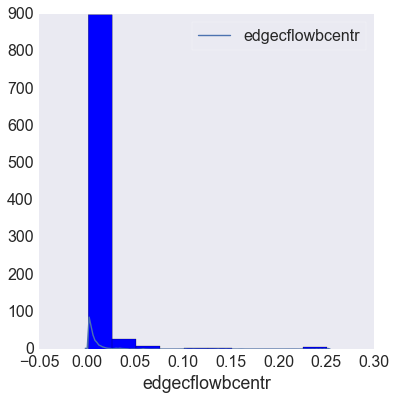

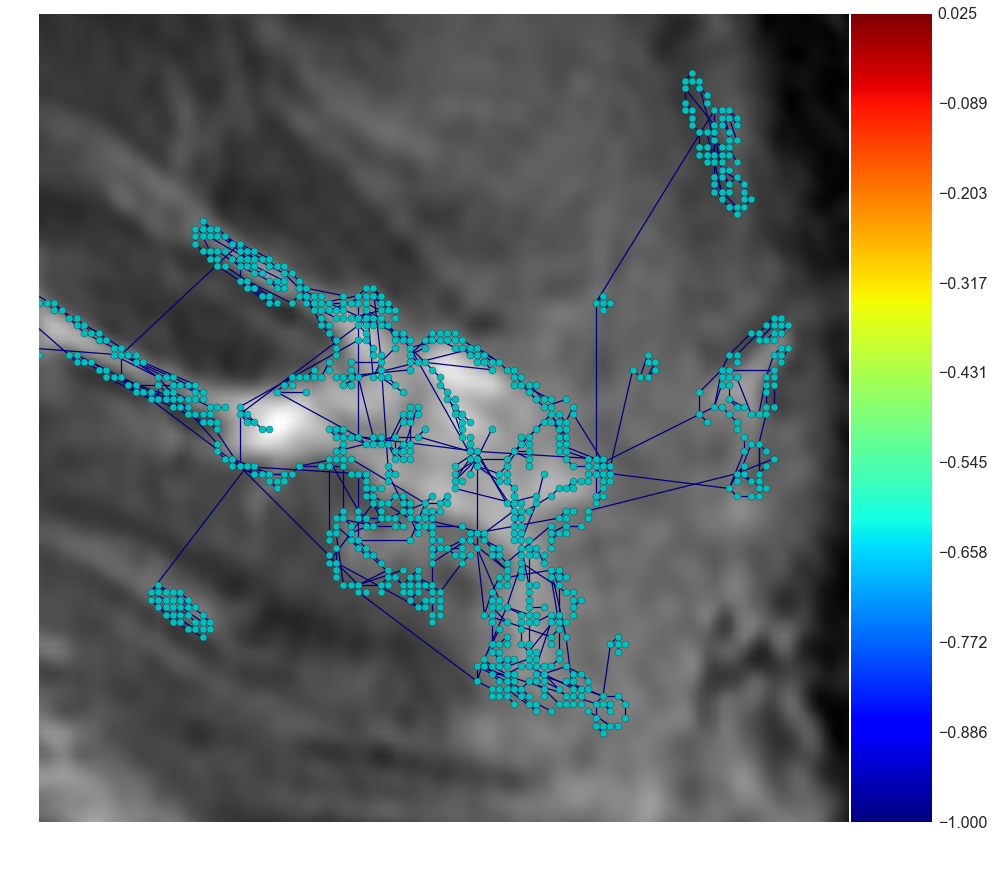

In [24]:
edgecflowbcentr = nx.edge_current_flow_betweenness_centrality(lesionG)
pd_edgecflowbcentr = pd.Series(edgecflowbcentr.values(), name="edgecflowbcentr")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(edgecflowbcentr.values(),color='b')
sns.distplot(pd_edgecflowbcentr, label="edgecflowbcentr", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
edgecflowbcentrvals = np.asarray([edgecflowbcentr.get(ed) if edgecflowbcentr.get(ed)!=None else -1 for ed in lesionG.edges()])
v = np.linspace(min(edgecflowbcentrvals), max(edgecflowbcentrvals), 10, endpoint=True) 
nxg = nx.draw_networkx_edges(lesionG, pos, ax=ax, edge_color=edgecflowbcentrvals, edge_cmap=plt.cm.jet,  
                 edge_vmin=min(edgecflowbcentrvals), edge_vmax=max(edgecflowbcentrvals),
                 with_labels=False, width=1.25)
nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_size=50, node_color='c')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('edgecflowbcentr')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)

# Katz centrality for the nodes of the graph G.

Katz centrality is related to eigenvalue centrality and PageRank. The Katz centrality for node i is

$$ x_i = \alpha \sum_{j} A_{ij} x_j + \beta $$

where  $A$  is the adjacency matrix of the graph  $G$  with eigenvalues  $\lambda$.
The parameter  $\beta$  controls the initial centrality and

$\alpha < \frac{1}{\lambda_{max}}$.


Katz centrality computes the relative influence of a node within a network by measuring the number of the immediate neighbors (first degree nodes) and also all other nodes in the network that connect to the node under consideration through these immediate neighbors.

Extra weight can be provided to immediate neighbors through the parameter $\beta$. Connections made with distant neighbors are, however, penalized by an attenuation factor  $\alpha$  which should be strictly less than the inverse largest eigenvalue of the adjacency matrix in order for the Katz centrality to be computed correctly. More information is provided in [1].

### Notes
This algorithm it uses the power method to find the eigenvector corresponding to the largest eigenvalue of the adjacency matrix of G. The constant alpha should be strictly less than the inverse of largest eigenvalue of the adjacency matrix for the algorithm to converge. The iteration will stop after max_iter iterations or an error tolerance of number_of_nodes(G)*tol has been reached.

When  $\alpha = 1/\lambda_{max}$  and  $\beta = 1$  Katz centrality is the same as eigenvector centrality.

For directed graphs this finds “left” eigenvectors which corresponds to the in-edges in the graph. For out-edges Katz centrality first reverse the graph with G.reverse().

### References
[1] M. Newman, Networks: An Introduction. Oxford University Press, USA, 2010, p. 720.

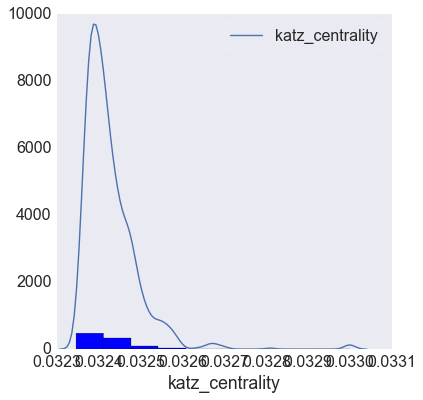

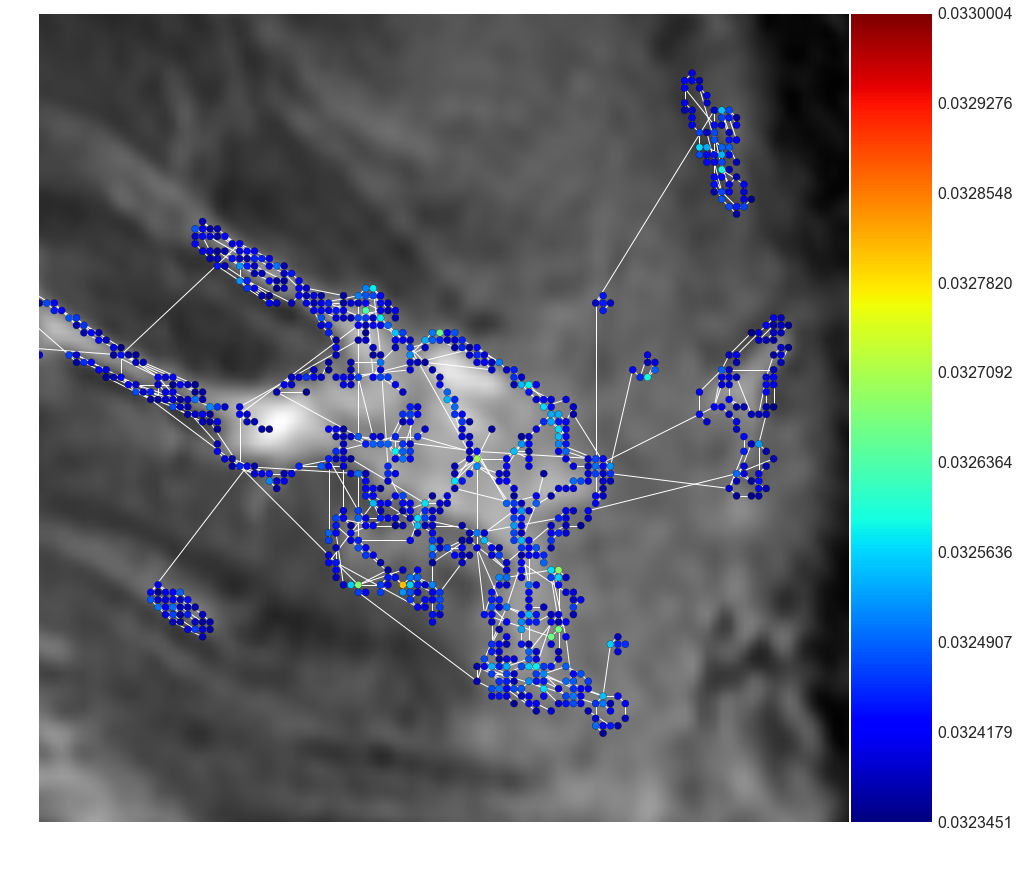

In [25]:
katz_centrality = nx.katz_centrality(lesionG, max_iter=5000)
pd_katz_centrality = pd.Series(katz_centrality.values(), name="katz_centrality")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(katz_centrality.values(),color='b')
sns.distplot(pd_katz_centrality, label="katz_centrality", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
katz_centralityvals = np.asarray([katz_centrality.get(node) for node in lesionG.nodes()])
v = np.linspace(min(katz_centralityvals), max(katz_centralityvals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=katz_centralityvals, cmap=plt.cm.jet,  
                 node_vmin=min(katz_centralityvals), node_vmax=max(katz_centralityvals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('katz_centrality')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)    

# Load centrality for nodes.
The load centrality of a node is the fraction of all shortest paths that pass through that node.

### Notes
Load centrality is slightly different than betweenness. It was originally introduced by [2]. For this load algorithm see [1].

### References
[1] Mark E. J. Newman: Scientific collaboration networks. II. Shortest paths, weighted networks, and centrality. Physical Review E 64, 016132, 2001. http://journals.aps.org/pre/abstract/10.1103/PhysRevE.64.016132

[2] Kwang-Il Goh, Byungnam Kahng and Doochul Kim Universal behavior of Load Distribution in Scale-Free Networks. Physical Review Letters 87(27):1–4, 2001. http://phya.snu.ac.kr/~dkim/PRL87278701.pdf

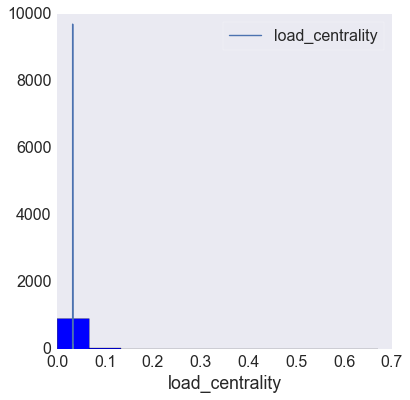

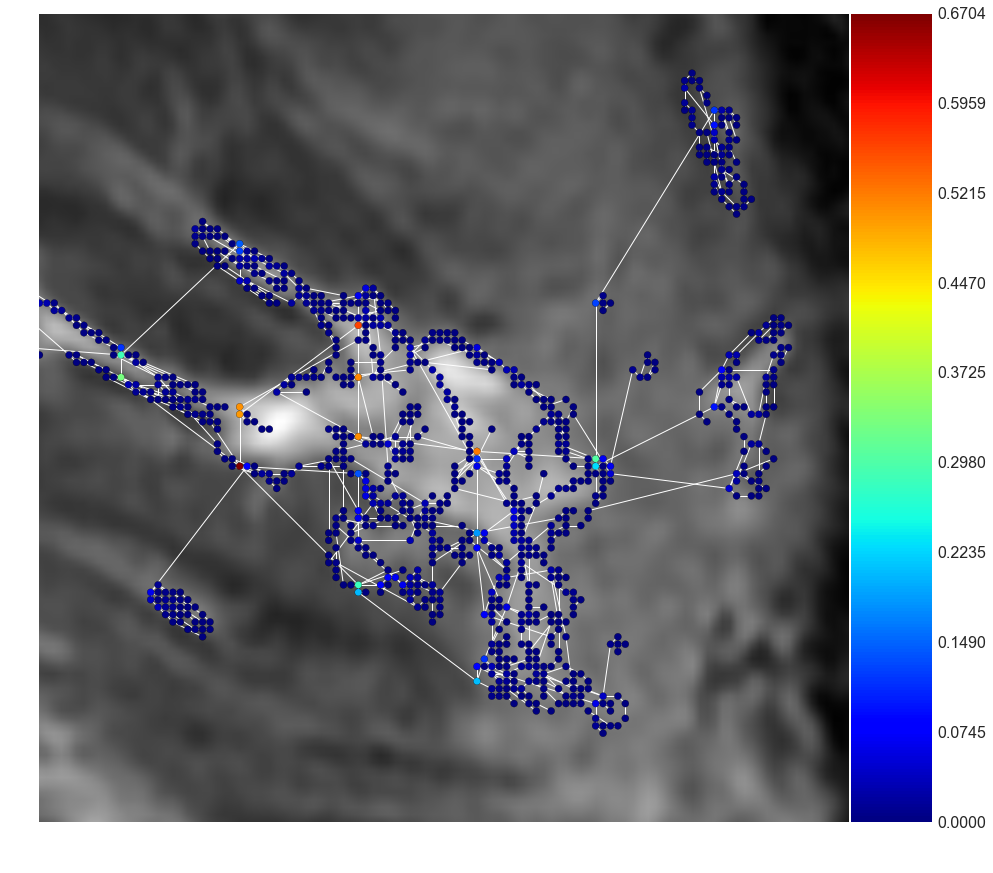

In [26]:
load_centrality = nx.load_centrality(lesionG)
pd_load_centrality = pd.Series(katz_centrality.values(), name="load_centrality")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(load_centrality.values(),color='b')
sns.distplot(pd_load_centrality, label="load_centrality", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
load_centralityvals = np.asarray([load_centrality.get(node) for node in lesionG.nodes()])
v = np.linspace(min(load_centralityvals), max(load_centralityvals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=load_centralityvals, cmap=plt.cm.jet,  
                 node_vmin=min(load_centralityvals), node_vmax=max(load_centralityvals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('load_centrality')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)   

## Clustering Coefficient for nodes.
For weighted graphs, the clustering is defined as the geometric average of the subgraph edge weights [1],

$$c_u = \frac{1}{deg(u)(deg(u)-1))}
     \sum_{uv} (\hat{w}_{uv} \hat{w}_{uw} \hat{w}_{vw})^{1/3}.$$

The edge weights  $\hat{w}_{uv}$ are normalized by the maximum weight in the network  $\hat{w}_{uv} = w_{uv}/\max(w)$
.
The value of  $c_u$ is assigned to 0 if deg(u) < 2.

Another definition is as follows [Saramaki2007]:
the weighted clustering coefficient should also take into account how much weight is present in the neighborhood of the vertex, compared to some limiting case. Evidently, this can be done in several ways, and in what follows we focus on four existing definitions.
In all these formulas, $$w_{ii} = 0 ∀i$, i.e., self-edges are not allowed, and $j ,k \in v_i$.
Barrat et al. were the first to propose a weighted version of the clustering coefficient [4]. Their definition reads as
$$ C ˜ i,B = ki?ki − 1??j,k ?wi? aijajkaik$$
 
where  $wi?=?jwij /ki$. As the rewritten form shows clearly, the contribution of each triangle is weighted by a ratio of the average weight of the two adjacent edges of the triangle to the

...the clustering coefficient is a basic measure for local density (connections) in a network. The number gives a 'probability' that two friends of a node are connected too (if A is connected to B and to C, how probable is the connections between B and C) . 

An alternative view: it counts the number of triangles around a node, divided by the possible number of triangles around a node. All these numbers are local (node-related). To obtain the overall clustering coefficient of a network one takes the mean value of all node-related clustering coefficients.


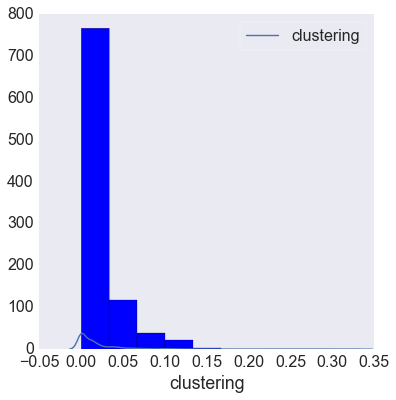

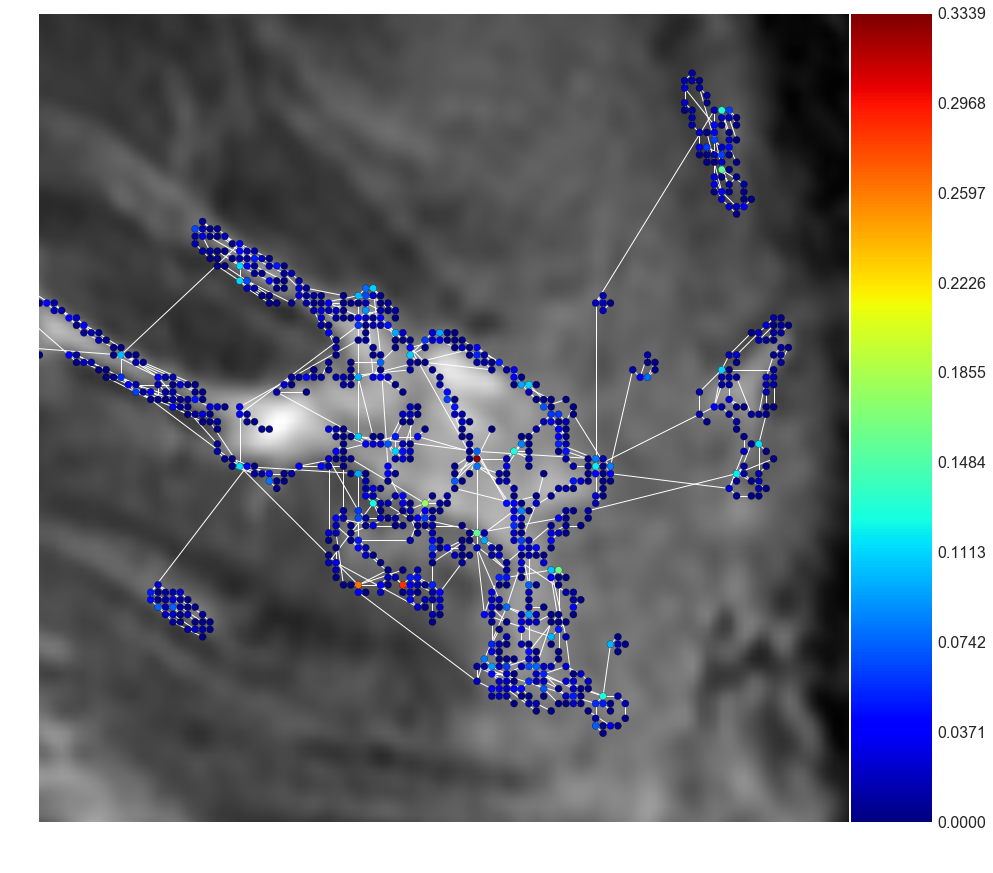

In [27]:
## NOTE: clustering coefficient replaced/updated as follows:
# recalculate clustering coefficient
nodes = [u for (u,v) in lesionG.nodes(data=True)]
#weights = [d['weight'] for (u,v,d) in lesionG.edges(data=True)]
edgesdict = lesionG.edge
clustering = []
for nij  in nodes:
    #print 'node = %d' % nij
    # The pairs must be given as 2-tuples (u, v) where u and v are nodes in the graph. 
    node_adjacency_dict = edgesdict[nij]
    cc_total = 0.0
    for pairs in itertools.combinations(lesionG.neighbors_iter(nij), 2):
        #print pairs
        adjw = np.sum([node_adjacency_dict[pairs[0]].get("weight",0), node_adjacency_dict[pairs[1]].get("weight",0)])/2.0
        cc_total += adjw
    #print cc_total    
    clustering.append( cc_total )
    
pd_clustering = pd.Series(clustering, name="clustering")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(clustering,color='b')
sns.distplot(pd_clustering, label="clustering", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
clustering_vals = np.asarray([c for c in clustering])
v = np.linspace(min(clustering_vals), max(clustering_vals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=clustering_vals, cmap=plt.cm.jet,  
                 node_vmin=min(clustering_vals), node_vmax=max(clustering_vals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('clustering')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)    

# Jaccard coefficient of all node pairs in ebunch.
Jaccard coefficient of nodes u and v is defined as
$$ \frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|} $$
 
where  $\Gamma(u)$  denotes the set of neighbors of  u.

### References
[1] D. Liben-Nowell, J. Kleinberg. The Link Prediction Problem for Social Networks (2004). http://www.cs.cornell.edu/home/kleinber/link-pred.pdf

In [28]:
jaccard = nx.jaccard_coefficient(lesionG)
## Returns:	An iterator of 3-tuples in the form (u, v, p) where (u, v) is a pair of nodes and p is their Jaccard coefficient.
alljac = []
for u, v, p in jaccard:
    alljac.append(p)
    
## total of len(alljac) = 31626

# Rich-club coefficient of the graph G.
The rich-club coefficient is the ratio, for every degree k, of the number of actual to the number of potential edges for nodes with degree greater than k:

$$\phi(k) = \frac{2 Ek}{Nk(Nk-1)} $$
 
where Nk is the number of nodes with degree larger than k, and Ek be the number of edges among those nodes.

### Notes
The rich club definition and algorithm are found in [R269]. This algorithm ignores any edge weights and is not defined for directed graphs or graphs with parallel edges or self loops.

Estimates for appropriate values of Q are found in [R270].

### References
[R269] (1, 2, 3) Julian J. McAuley, Luciano da Fontoura Costa, and Tibério S. Caetano, “The rich-club phenomenon across complex network hierarchies”, Applied Physics Letters Vol 91 Issue 8, August 2007. http://arxiv.org/abs/physics/0701290

[R270] (1, 2) R. Milo, N. Kashtan, S. Itzkovitz, M. E. J. Newman, U. Alon, “Uniform generation of random graphs with arbitrary degree sequences”, 2006. http://arxiv.org/abs/cond-mat/0312028

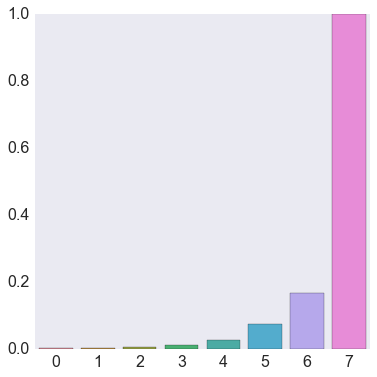

In [29]:
rich_club = nx.rich_club_coefficient(lesionG, normalized=False) 
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
sns.barplot(x =rich_club.keys(), y=rich_club.values(), label="rich_club_coefficient by degree", ax=ax)

## Closeness vitality for nodes.
Closeness vitality of a node is the change in the sum of distances between all node pairs when excluding that node.

### References
[R273] Ulrik Brandes, Sec. 3.6.2 in Network Analysis: Methodological Foundations, Springer, 2005. http://books.google.com/books?id=TTNhSm7HYrIC


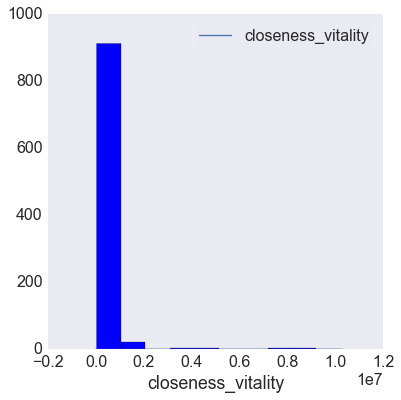

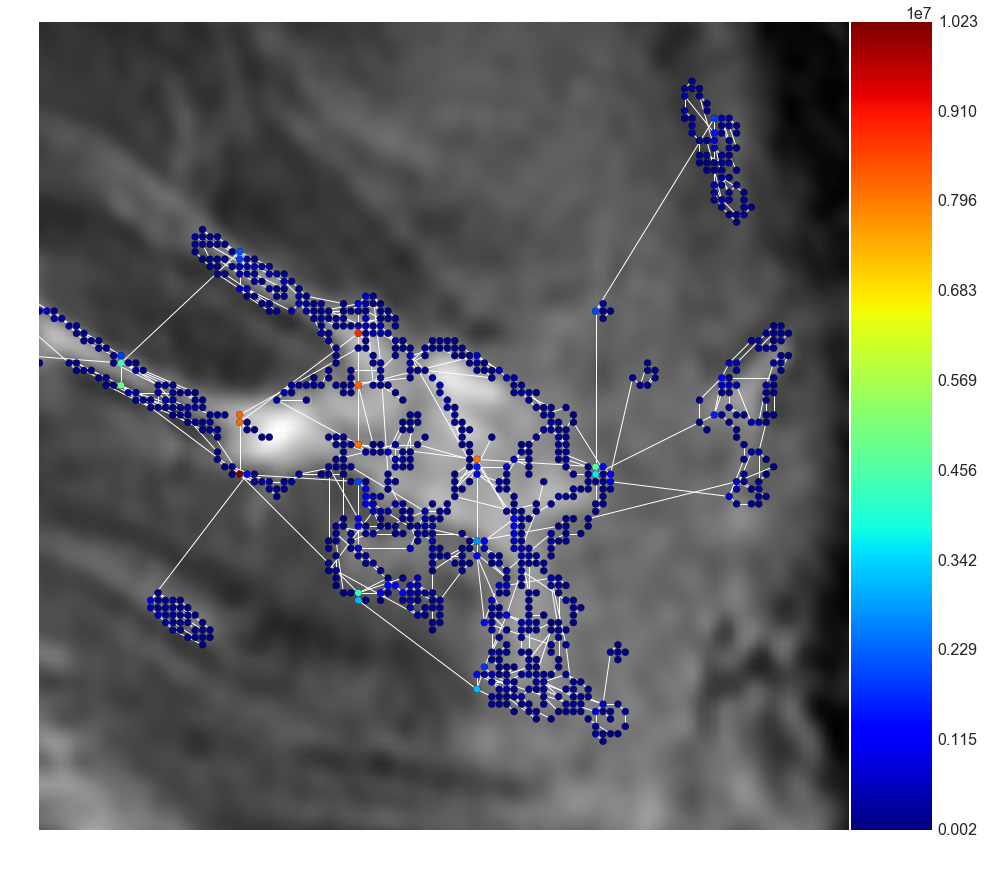

In [31]:
closeness_vitality = nx.closeness_vitality(lesionG, weight='weigth')
pd_closeness_vitality = pd.Series(closeness_vitality.values(), name="closeness_vitality")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(closeness_vitality.values(),color='b')
sns.distplot(pd_closeness_vitality, label="closeness_vitality", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)             
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
closeness_vitalityvals = np.asarray([closeness_vitality.get(node) for node in lesionG.nodes()])
v = np.linspace(min(closeness_vitalityvals), max(closeness_vitalityvals), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=closeness_vitalityvals, cmap=plt.cm.jet,  
                 node_vmin=min(closeness_vitalityvals), node_vmax=max(closeness_vitalityvals),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax, width=1, edge_color='w')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('closeness_vitality')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 